In [55]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score)

In [33]:
data = pd.read_pickle('data.pkl')

In [35]:
data.isnull().sum().sort_values(ascending=False)[:25]

Bene_Race_API_Cnt                  573945
Bene_Race_Othr_Cnt                 565247
Bene_CC_BH_ADHD_OthCD_V1_Pct       544917
Bene_CC_BH_PTSD_V1_Pct             529476
Bene_CC_BH_PD_V1_Pct               523444
Bene_Race_Hspnc_Cnt                503248
Bene_CC_PH_Parkinson_V2_Pct        472242
Bene_CC_BH_Schizo_OthPsy_V1_Pct    449855
Bene_Race_Black_Cnt                435593
Bene_Race_NatInd_Cnt               407872
Bene_CC_BH_Bipolar_V1_Pct          366956
Bene_Age_GT_84_Cnt                 273168
Bene_CC_BH_Alcohol_Drug_V1_Pct     260005
Bene_Age_LT_65_Cnt                 256286
Bene_CC_BH_Alz_NonAlzdem_V2_Pct    240505
Bene_CC_PH_Stroke_TIA_V2_Pct       196038
Bene_CC_BH_Tobacco_V1_Pct          193062
Bene_CC_PH_Asthma_V2_Pct           158946
Bene_Dual_Cnt                      149019
Bene_Ndual_Cnt                     149019
Bene_CC_PH_Osteoporosis_V2_Pct     135160
Bene_Age_75_84_Cnt                 131318
Bene_CC_PH_Cancer6_V2_Pct          125226
Bene_CC_PH_HF_NonIHD_V2_Pct       

In [36]:
sum((data.isnull().sum())>0)

53

# Preprocessing 
- Impute missing with -1 due to out of range for count, percent, and total cols
- Min Max for non normality

In [39]:
numerical_cols = np.load('numerical_cols.npy', allow_pickle = True)

In [41]:
data.isnull().sum()[(data.isnull().sum())>0].index.isin(numerical_cols)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [42]:
data = data.fillna(-1) # Impute null values with a negative value to denote empty

In [44]:
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [51]:
data.shape

(765761, 239)

# Tran and Val Split

In [45]:
raw_train, raw_val = train_test_split(data, test_size=0.2, random_state=1)

# Isolation Forest

In [46]:
# Isolation Forest
iforest_raw = IsolationForest(n_estimators=100, random_state=1)
iforest_raw.fit(raw_train)

# Predict anomaly scores for training and validation sets
train_scores_raw = iforest_raw.decision_function(raw_train)
val_scores_raw = iforest_raw.decision_function(raw_val)
# Export the anomaly scores to numpy files
np.save('train_scores_raw.npy', train_scores_raw)
np.save('val_scores_raw.npy', val_scores_raw)

In [47]:
# Export the Isolation Forest model to a pickle file
with open('isolation_forest_raw.pkl', 'wb') as f:
    pickle.dump(iforest_raw, f)

In [48]:
# Predict anomalies on the validation set
anomaly_predictions_val_raw = iforest_raw.predict(raw_val)

# Calculate metrics on the validation set
silhouette_val_raw = silhouette_score(raw_val, anomaly_predictions_val_raw)
calinski_harabasz_val_raw = calinski_harabasz_score(raw_val, anomaly_predictions_val_raw)
davies_bouldin_val_raw = davies_bouldin_score(raw_val, anomaly_predictions_val_raw)

print('Silhouette Coefficient (Validation):', silhouette_val_raw)
print('Calinski-Harabasz Index (Validation):', calinski_harabasz_val_raw)
print('Davies-Bouldin Index (Validation):', davies_bouldin_val_raw)


Silhouette Coefficient (Validation): -0.6012175068471142
Calinski-Harabasz Index (Validation): 6.053384488723438
Davies-Bouldin Index (Validation): 7.172186793228462


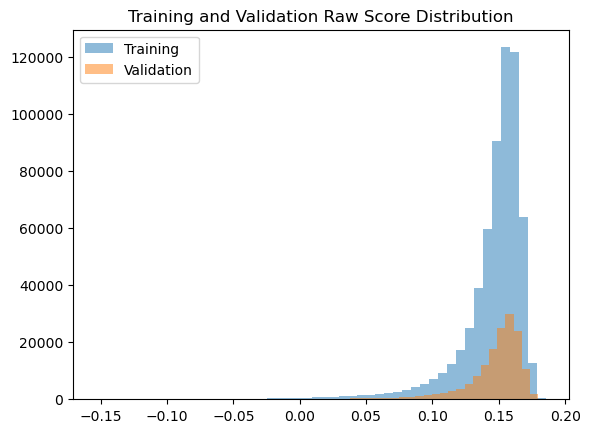

In [58]:
# Plot the anomaly scores
plt.title('Training and Validation Raw Score Distribution')
plt.hist(train_scores_raw, bins=50, alpha=0.5, label='Training')
plt.hist(val_scores_raw, bins=50, alpha=0.5, label='Validation')
plt.legend()
plt.show()

In [50]:
# Predict anomalies for training and validation sets
train_predictions_raw = iforest_raw.predict(raw_train)
val_predictions_raw = iforest_raw.predict(raw_val)

# Calculate the anomaly detection rates
train_anomaly_rate_raw = np.mean(train_predictions_raw == -1)
val_anomaly_rate_raw = np.mean(val_predictions_raw == -1)

# Print the anomaly detection rates
print('Training Anomaly Rate:', train_anomaly_rate_raw)
print('Validation Anomaly Rate:', val_anomaly_rate_raw)

Training Anomaly Rate: 0.004425342143752612
Validation Anomaly Rate: 0.0041592394533571005


# PCA Outlier Visualization

In [56]:
# Apply PCA
pca = PCA(n_components=2, random_state=1)
pca_data = pca.fit_transform(raw_val)

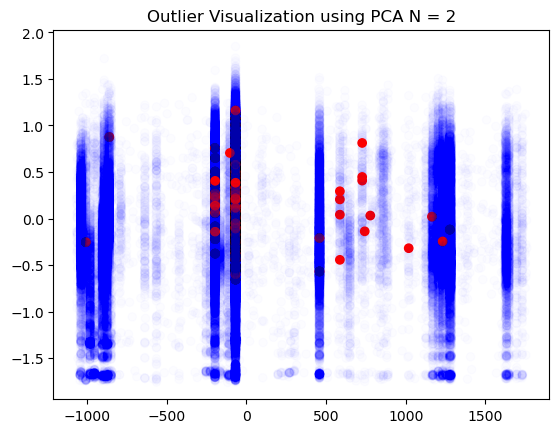

In [60]:
# Plot the data points
plt.title('Outlier Visualization using PCA N = 2')
plt.scatter(pca_data[:, 0], pca_data[:, 1], 
             c=['red' if label == -1 else 'blue' for label in anomaly_predictions_val_raw],
             alpha=[1.0 if label == -1 else 0.01 for label in anomaly_predictions_val_raw])
plt.show()